In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP
from layers import GraphConv
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.sparse.csgraph import connected_components

from tqdm import trange
import numpy as np
import copy 
import time
import pickle
import os

DATASET = 'citeseer'
SAVE_DIR = './exp_results/figures/%s/'%DATASET

layers = [i for i in range(2,10)]
repeats = [i for i in range(10)] 

In [34]:
def get_mean_sigW(w_sigval):
    sigW_ = list()
    for k, v in w_sigval.items():
        if 'gcs.0' in k:
            continue
        elif 'gcs' in k:
            sigW_.append(v)
    sigW_ = np.mean(sigW_) if len(sigW_) > 0 else 1
    return sigW_

In [43]:
ALGORITHM = 'APPNP'

def get_dM_sigW_dist(algo, layer=10):
    dM_before = []
    dM_after = []
    sigW_before = []
    sigW_after = []
    inner_dist = []
    cross_dist = []

    for repeat in repeats:
        save_path = os.path.join('exp_results/%s/'%DATASET, 
                                 'results_%s_L%d_repteat%d.pkl'%(DATASET, layer, repeat))
        with open(save_path, 'rb') as f:
            results_list = pickle.load(f)

        for result in results_list:
            if result.note == '%s (L=%d)'%(algo, layer):
                break

        dM_before.append(result.dM_before)
        dM_after.append(result.dM_after)
        sigW_before.append(get_mean_sigW(result.w_sigval_before))
        sigW_after.append(get_mean_sigW(result.w_sigval_after))
        inner_dist.append(result.inner_dist_after)
        cross_dist.append(result.cross_dist_after)
    return dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist

def get_result(algo, layer=10):
    train_acc_record = []
    train_loss_record = []
    valid_acc_record = []
    valid_loss_record = []
    test_acc_record = []
    
    for repeat in repeats:
        save_path = os.path.join('exp_results/%s/'%DATASET, 
                                 'results_%s_L%d_repteat%d.pkl'%(DATASET, layer, repeat))
        with open(save_path, 'rb') as f:
            results_list = pickle.load(f)

        for result in results_list:
            if result.note == '%s (L=%d)'%(algo, layer):
                break

        train_acc_record.append(result.train_acc_record)
        train_loss_record.append(result.train_loss_record)
        valid_acc_record.append(result.acc_record)
        valid_loss_record.append(result.loss_record)
        test_acc_record.append(result.test_acc)
    return train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record

#1f77b4
#1f77b4
#ff7f0e
#ff7f0e
#2ca02c
#2ca02c
#d62728
#d62728


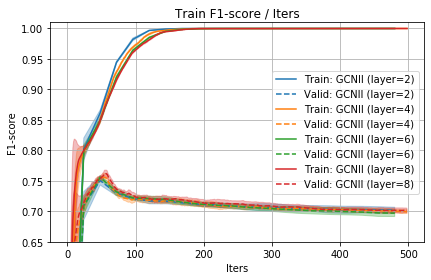

In [47]:
fig, axs = plt.subplots()

for ALGORITHM in ['GCNII']:
    for layer in layers:
        if layer % 2 != 0:
            continue
            
        skip = int(len(y_vals)/20)
        train_acc_record, train_loss_record, valid_acc_record, valid_loss_record, test_acc_record = get_result(ALGORITHM, layer)

        data_mat = np.array(train_acc_record)
        y_vals = np.mean(data_mat, axis=0)
        y_stds = np.std(data_mat, axis=0)
        
        y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skip)]]
        y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skip)]]
        x_vals = np.arange(len(y_vals))*skip
        
        color = next(axs._get_lines.prop_cycler)['color']
        print(color)
        axs.plot(x_vals, y_vals, label='Train: %s (layer=%d)'%(ALGORITHM, layer), color=color, linestyle='-')
        axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color)
        
        data_mat = np.array(valid_acc_record)
        y_vals = np.mean(data_mat, axis=0)
        y_stds = np.std(data_mat, axis=0)
        
        y_vals = y_vals[[i for i in range(0,len(y_vals)-1, skip)]]
        y_stds = y_stds[[i for i in range(0,len(y_stds)-1, skip)]]
        x_vals = np.arange(len(y_vals))*skip
        
        print(color)
        axs.plot(x_vals, y_vals, label='Valid: %s (layer=%d)'%(ALGORITHM, layer), color=color, linestyle='--')
        axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3, color=color)
        
        

plt.title('Train F1-score / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('F1-score')
axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.ylim(0.65,1.01)
plt.legend()

plt.savefig('train_acc_%s_%s.pdf'%(DATASET, ALGORITHM))
# plt.close()

In [40]:
skip

0

In [5]:
# fig, axs = plt.subplots()

# for ALGORITHM in ['GCN', 'GCNBias', 'SGC']:
#     dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
#     data_mat = np.array(dM_before)
#     avg_sigW = np.mean(sigW_before)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Before training (average $\lambda_\max(W^{(\ell)})=$%.2f)'%(ALGORITHM, avg_sigW))
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

#     data_mat = np.array(dM_after)
#     avg_sigW = np.mean(sigW_after)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: After training (average $\lambda_\max(W^{(\ell)})=$%.2f)'%(ALGORITHM, avg_sigW))
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

# plt.title('$d_M(H^{(\ell)})$ / Num of layers')
# axs.set_xlabel('Num of layers')
# axs.set_ylabel('$d_M(H^{(\ell)})$')
# axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# fig.tight_layout()
# plt.ylim(0,5)
# plt.legend()

# plt.savefig('dM_sigW_%s_%s_without_res.pdf'%(DATASET, ALGORITHM))
# plt.close()

In [6]:
# fig, axs = plt.subplots()

# for ALGORITHM in ['ResGCN', 'GCNII', 'APPNP']:
#     dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
#     data_mat = np.array(dM_before)
#     avg_sigW = np.mean(sigW_before)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Before training (average $\lambda_\max(W^{(\ell)})=$%.2f)'%(ALGORITHM, avg_sigW))
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

#     data_mat = np.array(dM_after)
#     avg_sigW = np.mean(sigW_after)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: After training (average $\lambda_\max(W^{(\ell)})=$%.2f)'%(ALGORITHM, avg_sigW))
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

# plt.title('$d_M(H^{(\ell)})$ / Num of layers')
# axs.set_xlabel('Num of layers')
# axs.set_ylabel('$d_M(H^{(\ell)})$')
# axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# fig.tight_layout()
# plt.ylim(0,5)
# plt.legend()

# plt.savefig('dM_sigW_%s_%s_with_res.pdf'%(DATASET, ALGORITHM))
# plt.close()

In [7]:
# fig, axs = plt.subplots()

# for ALGORITHM in ['SGC']:
#     dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
#     data_mat = np.array(inner_dist)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Inner distance'%ALGORITHM)
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

#     data_mat = np.array(cross_dist)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Cross distance'%ALGORITHM)
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
    
#     data_mat = np.array(cross_dist) - np.array(inner_dist)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Cross distance - Inner dist'%ALGORITHM)
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
    

# plt.title('Inner and cross distance / Num of layers')
# axs.set_xlabel('Num of layers')
# axs.set_ylabel('Inner and cross distance')
# axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# fig.tight_layout()
# # plt.ylim(0,5)
# plt.legend()

# plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
# plt.close()

In [8]:
# fig, axs = plt.subplots()

# for ALGORITHM in ['APPNP']:
#     dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
#     data_mat = np.array(inner_dist)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Inner distance'%ALGORITHM)
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

#     data_mat = np.array(cross_dist)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Cross distance'%ALGORITHM)
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

#     data_mat = np.array(cross_dist) - np.array(inner_dist)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Cross distance - Inner dist'%ALGORITHM)
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
    
# plt.title('Inner and cross distance / Num of layers')
# axs.set_xlabel('Num of layers')
# axs.set_ylabel('Inner and cross distance')
# axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# fig.tight_layout()
# plt.legend()

# plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
# plt.close()

In [9]:
# fig, axs = plt.subplots()

# for ALGORITHM in ['GCN']:
#     dM_before, dM_after, sigW_before, sigW_after, inner_dist, cross_dist = get_dM_sigW_dist(ALGORITHM)
#     data_mat = np.array(inner_dist)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Inner distance'%ALGORITHM)
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

#     data_mat = np.array(cross_dist)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Cross distance'%ALGORITHM)
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
    
#     data_mat = np.array(cross_dist) - np.array(inner_dist)
#     y_vals = np.mean(data_mat, axis=0)
#     y_stds = np.std(data_mat, axis=0)
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label='%s: Cross distance - Inner dist'%ALGORITHM)
#     axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

# plt.title('Inner and cross distance / Num of layers')
# axs.set_xlabel('Num of layers')
# axs.set_ylabel('Inner and cross distance')
# axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# fig.tight_layout()
# plt.legend()

# plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
# plt.close()